In [62]:
import autograd.numpy as np
import pandas as pd
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

First we will load the data to see what we are dealing with and we will plot a short animation

In [7]:
#load the data 
import h5py
name = 'mouse_second_video.mp4.predictions.analysis.h5'
with h5py.File(name, 'r') as f:
    occupancy_matrix = f['track_occupancy'][:]
    tracks_matrix = f['tracks'][:]

tracks_matrix = tracks_matrix[0]
print(occupancy_matrix.shape)
print(tracks_matrix.shape)

(934, 1)
(2, 7, 934)


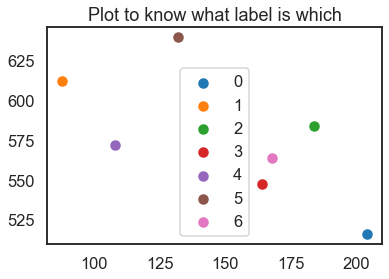

In [79]:
#This helps us identify which point is which 

for i in range(7):
    plt.scatter(tracks_matrix[0,i,650],tracks_matrix[1,i,650],label=i)


plt.title("Plot to know what label is which")
plt.legend()


t:   2%|▏         | 3/200 [00:00<00:07, 24.91it/s, now=None]Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

                                                              Moviepy - Done !
Moviepy - video ready __temp__.mp4


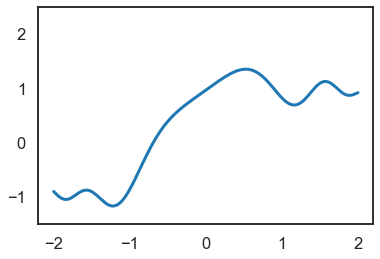

In [148]:
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

x = np.linspace(-2, 2, 200)

duration = 10

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
    ax.set_ylim(-1.5, 2.5)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=20, loop=True, autoplay=True)



In [ ]:
for k in range(n_disc_states):
    curr_states = states_x[states_z == k]
    plt.plot(curr_states[:,0],
             curr_states[:,1],
             '-',
             color=colors[k],
             lw=3,
             label="$z=%i$" % k)
    
    # Draw lines connecting the latent state between discrete state transitions,
    # so they don't show up as broken lines.
    next_states = states_x[states_z == k+1]
    if len(next_states) > 0 and len(curr_states) > 0:
        plt.plot((curr_states[-1,0], next_states[0,0]),
                 (curr_states[-1,1], next_states[0,1]),
                 '-',
                 color='gray',
                 lw=1)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

plt.figure(figsize=(10,2))
cmap_limited = ListedColormap(colors[0:n_disc_states])
plt.imshow(states_z[None,:],  aspect="auto", cmap=cmap_limited)
plt.title("Simulated Discrete Latent States")
plt.yticks([])
plt.xlabel("Time")
plt.show()

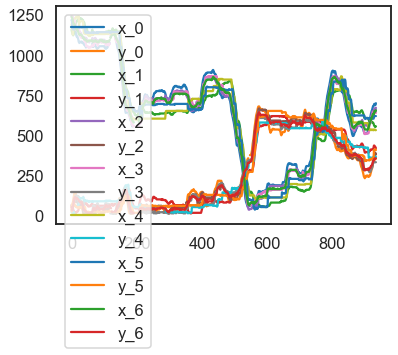

In [50]:
for i in range(7):
    plt.plot(tracks_matrix[0,i,:],label= "x_{}".format(i))
    plt.plot(tracks_matrix[1,i,:],label="y_{}".format(i))

plt.legend()




In [135]:
# Now we need to clean the data.
# I will do this by centering the data an dealing with nan values by interpolation 
# I will ignore the first 30 frames because they are particularly bad 
clean = np.zeros(tracks_matrix.shape)
start = 30

# We will make it so that the center of the coordinate system is the head 
for position in range(7):
    for coordinate in range(2):
        clean[coordinate,position] = np.array(pd.Series(tracks_matrix[coordinate,position]).interpolate())

# We will make it so that the center of the coordinate system is the head 
#head_position = clean[:,0].copy()
#print(head_position)
for position in range(7):
    for coordinate in range(2): 
        clean[coordinate,position] = (clean[coordinate,position] - head_position[coordinate]).copy()


clean = clean[:,:,start:]

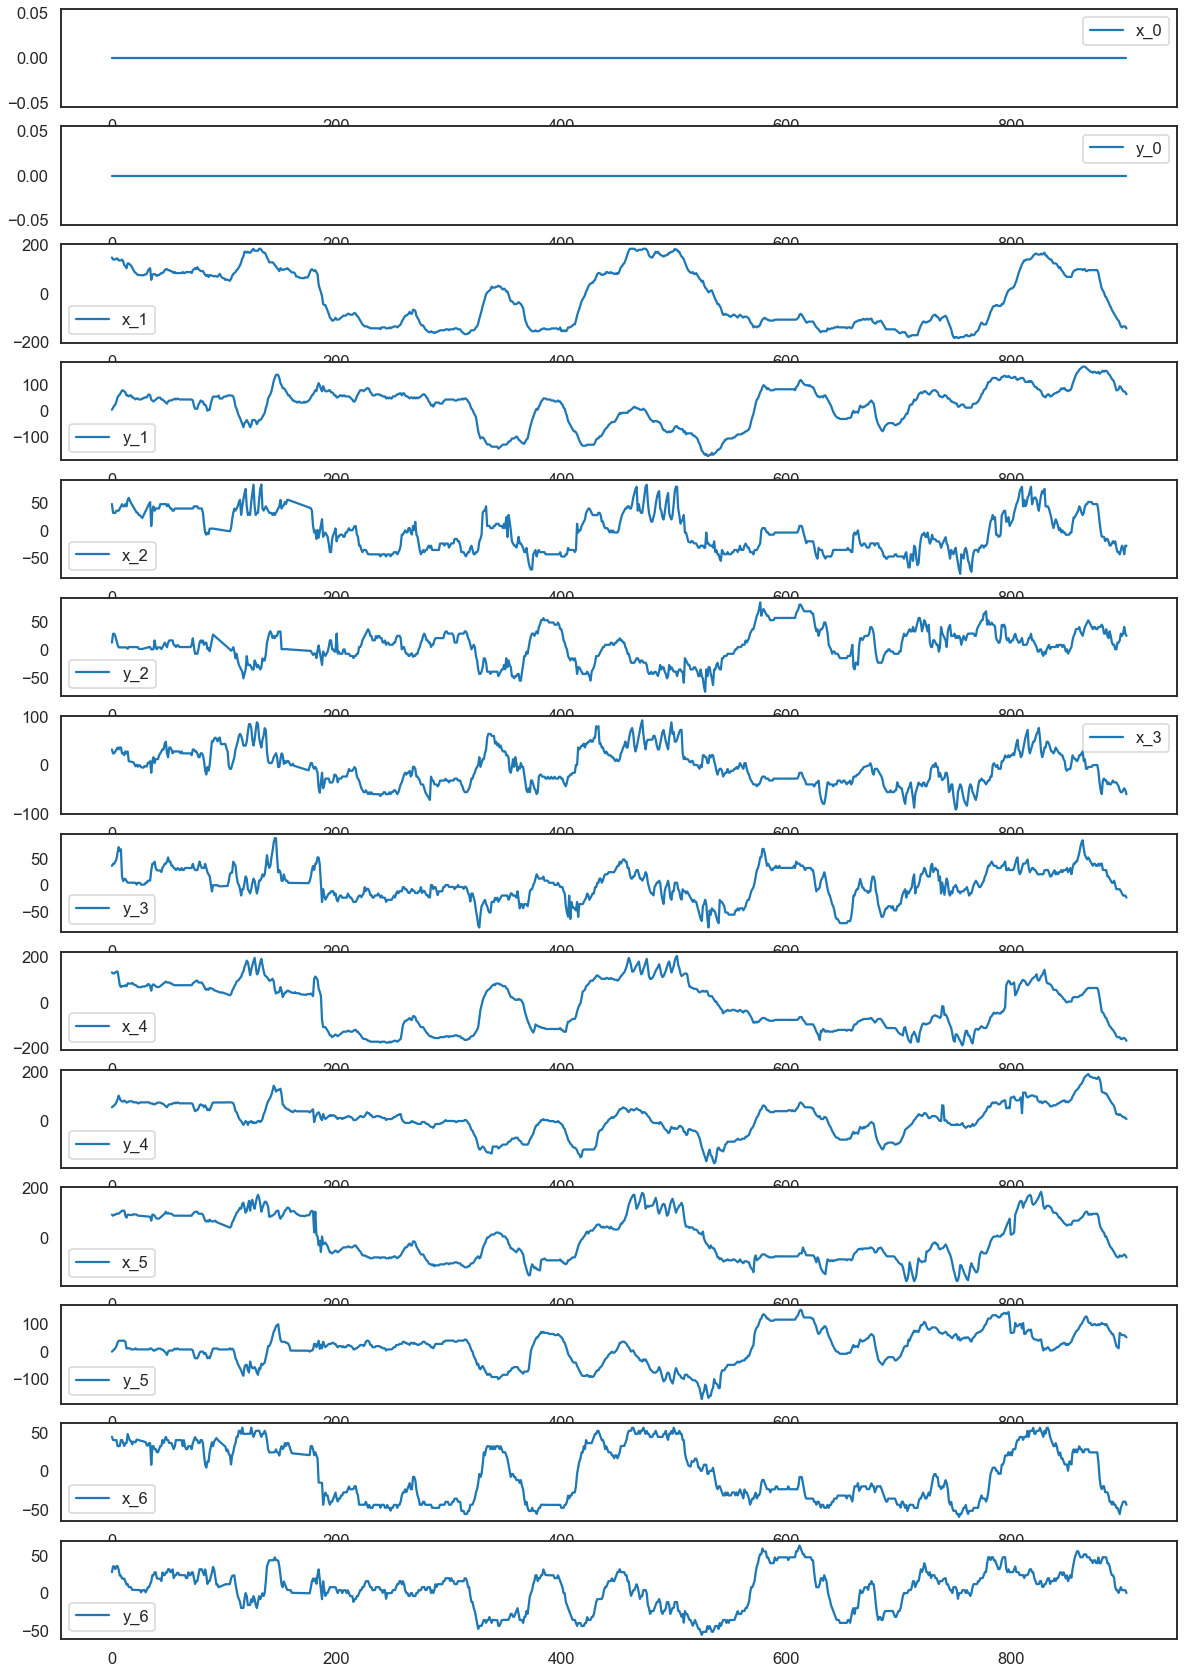

In [140]:
fig, axs = plt.subplots(14,figsize=(20,30))

for i in range(7):
    axs[2*i].plot(clean[0,i,:],label= "x_{}".format(i))
    axs[2*i].legend()
    axs[2*i+1].plot(clean[1,i,:],label="y_{}".format(i))
    axs[2*i+1].legend()

plt.legend()

In [141]:
emissions = clean.reshape(-1,clean.shape[-1]).T
emissions.shape

(904, 14)

In [142]:
emissions_dim = emissions.shape[-1]
n_disc_states = 6
latent_dim = 5
emissions_func ='gaussian_orthog'
slds = ssm.SLDS(emissions_dim, n_disc_states,latent_dim, emissions=emissions_func)
# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(emissions, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=100, alpha=0.0)

# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_lem_z = slds.most_likely_states(q_lem_x, emissions)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, emissions)

LP: -49568.7:  24%|██▍       | 6/25 [00:00<00:00, 57.27it/s]Initializing with an ARHMM using 25 steps of EM.

ELBO: -41423.3: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


In [143]:
for i, j in enumerate(q_lem_z):
    print(i+30, j)

30 1
31 1
32 0
33 0
34 0
35 3
36 3
37 3
38 3
39 3
40 0
41 0
42 0
43 0
44 0
45 5
46 5
47 5
48 5
49 5
50 5
51 5
52 5
53 5
54 5
55 5
56 5
57 5
58 5
59 5
60 5
61 5
62 5
63 5
64 0
65 1
66 1
67 5
68 5
69 5
70 5
71 5
72 5
73 5
74 5
75 5
76 5
77 5
78 5
79 5
80 5
81 5
82 5
83 5
84 5
85 5
86 5
87 5
88 5
89 5
90 5
91 5
92 5
93 5
94 5
95 5
96 5
97 5
98 5
99 5
100 5
101 5
102 2
103 2
104 2
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 1
114 1
115 1
116 5
117 5
118 3
119 3
120 0
121 5
122 5
123 5
124 5
125 5
126 5
127 5
128 5
129 5
130 5
131 5
132 0
133 0
134 1
135 0
136 0
137 1
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 4
149 4
150 4
151 4
152 4
153 4
154 4
155 4
156 4
157 4
158 4
159 4
160 4
161 4
162 4
163 4
164 3
165 3
166 3
167 3
168 1
169 1
170 0
171 0
172 0
173 3
174 3
175 3
176 3
177 0
178 0
179 1
180 1
181 1
182 1
183 0
184 0
185 0
186 0
187 0
188 0
189 1
190 5
191 5
192 5
193 5
194 5
195 5
196 5
197 5
198 5
199 5
200 5
201 5
202 5
203 5
204 5
205 5
206 5
207 5
20

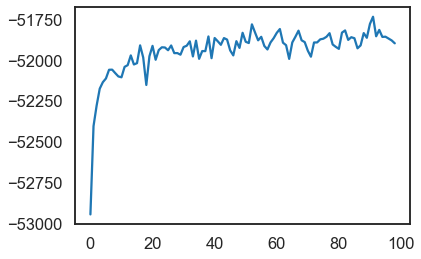

In [133]:
plt.plot(q_lem_elbos[2:])
